In [2]:
from split_dataset import load_indices
import os
import torch
from torch import nn, optim
from torch.utils.data import Subset, DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import Caltech101
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm

TEST_MODEL = "LR-Test_7"
BATCH_SIZE = 32
model_save_path = os.path.join("logs", TEST_MODEL, "best_model.pth")

# 数据准备
dataset = Caltech101(root="./data")
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5459, 0.5170, 0.4862], [0.3175, 0.3155, 0.3270])
])

class TransformApplier(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        data, target = self.subset[idx]
        data = data.convert("RGB")
        return self.transform(data), target

val_indices = load_indices("./data/caltech101/val_indices.txt")
val_dataset = Subset(dataset, val_indices)
val_dataset = TransformApplier(val_dataset, val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 训练准备
model = resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 101) 
model.load_state_dict(torch.load(model_save_path))
model = model.cuda()
loss_fn = nn.CrossEntropyLoss().cuda()

model.eval()
correct = 0
total = 0
running_loss = 0.0
class_correct = torch.zeros(101)
class_total = torch.zeros(101)
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i, label in enumerate(labels):
            class_correct[label.item()] += (predicted[i] == labels[i]).item()
            class_total[label.item()] += 1
        
val_acc = 100 * correct / total
epoch_loss = running_loss / len(val_dataset)
class_acc = class_correct / class_total
print(class_acc)
print(f'Validation Accuracy: {val_acc:.2f}%')

c:\ProgramData\Anaconda3\envs\pytorch-2.2.1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ProgramData\Anaconda3\envs\pytorch-2.2.1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\pytorch-2.2.1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tensor([0.1000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.4286, 0.7143, 0.7500,
        0.8889, 0.8571, 1.0000, 1.0000, 1.0000, 0.7143, 0.8000, 0.9000, 1.0000,
        0.4286, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 0.6250, 0.8000, 0.8000,
        0.9000, 0.3750, 0.8750, 1.0000, 1.0000, 1.0000, 0.9000, 1.0000, 0.7000,
        0.8000, 0.8750, 1.0000, 1.0000, 1.0000, 1.0000, 0.7143, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9000, 1.0000, 0.7778, 0.7000, 0.9000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.8000, 1.0000, 0.9000, 0.7143, 0.7000, 1.0000, 0.8333,
        1.0000, 1.0000, 1.0000, 0.8889, 0.3333, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.5000, 1.0000, 1.0000, 0.8889, 0.8750, 1.0000, 0.6000, 1.0000,
        1.0000, 0.7778, 0.8333, 0.9000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.8000, 0.8750, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000, 1.0000, 0.8889,
        0.8333, 1.0000])
Validation Accuracy: 89.16%


In [20]:
# 测试多个模型的分组准确率

from split_dataset import load_indices
import os
import torch
from torch import nn, optim
from torch.utils.data import Subset, DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import Caltech101
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm

# models_for_test = [f"From-Scratch_{i}" for i in range(2, 3)]
models_for_test = [f"LR-Test_{i}" for i in range(5, 10)]
target_class = [0, 18, 67, 95]
class_accs = []
class_predictions = []
for TEST_MODEL in models_for_test:
    BATCH_SIZE = 32
    model_save_path = os.path.join("logs", TEST_MODEL, "best_model.pth")

    # 数据准备
    dataset = Caltech101(root="./data")
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5459, 0.5170, 0.4862], [0.3175, 0.3155, 0.3270])
    ])

    class TransformApplier(Dataset):
        def __init__(self, subset, transform):
            self.subset = subset
            self.transform = transform

        def __len__(self):
            return len(self.subset)

        def __getitem__(self, idx):
            data, target = self.subset[idx]
            data = data.convert("RGB")
            return self.transform(data), target

    val_indices = load_indices("./data/caltech101/val_indices.txt")
    val_dataset = Subset(dataset, val_indices)
    val_dataset = TransformApplier(val_dataset, val_transform)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 训练准备
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 101) 
    model.load_state_dict(torch.load(model_save_path))
    model = model.cuda()
    loss_fn = nn.CrossEntropyLoss().cuda()
    class_predictions_per_model = [torch.zeros(101) for i in range(len(target_class))]

    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    class_correct = torch.zeros(101)
    class_total = torch.zeros(101)
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i, label in enumerate(labels):
                for j, target in enumerate(target_class):
                    if label == target:
                        class_predictions_per_model[j][predicted[i]] += 1
                class_correct[label.item()] += (predicted[i] == labels[i]).item()
                class_total[label.item()] += 1
            
    val_acc = 100 * correct / total

    epoch_loss = running_loss / len(val_dataset)
    class_acc = class_correct / class_total
    
    class_predictions.append(class_predictions_per_model)
    class_accs.append(class_acc)
    print(f'Validation Accuracy: {val_acc:.2f}%')

c:\ProgramData\Anaconda3\envs\pytorch-2.2.1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\pytorch-2.2.1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Validation Accuracy: 90.54%
Validation Accuracy: 90.08%
Validation Accuracy: 89.16%
Validation Accuracy: 91.58%
Validation Accuracy: 91.58%


In [19]:
print(class_total[18])
print(class_total[67])
class_total

tensor(7.)
tensor(6.)


tensor([10., 10., 10., 10.,  9., 10.,  7.,  7.,  8.,  9.,  7.,  5., 10., 10.,
         7., 10., 10.,  8.,  7., 10.,  8.,  9., 10., 10.,  8., 10., 10., 10.,
         8.,  8.,  9., 10.,  8., 10., 10., 10., 10.,  8., 10., 10., 10., 10.,
         7.,  6.,  6.,  8., 10., 10.,  7.,  9., 10., 10.,  5., 10., 10., 10.,
        10., 10., 10.,  7., 10.,  7.,  6., 10.,  5., 10.,  9.,  6.,  6.,  8.,
         6.,  7.,  8.,  6.,  9., 10.,  9.,  8.,  6., 10.,  6., 10.,  9.,  6.,
        10.,  7., 10.,  9., 10.,  6., 10.,  8., 10., 10., 10.,  6.,  9.,  6.,
         9.,  6.,  9.])

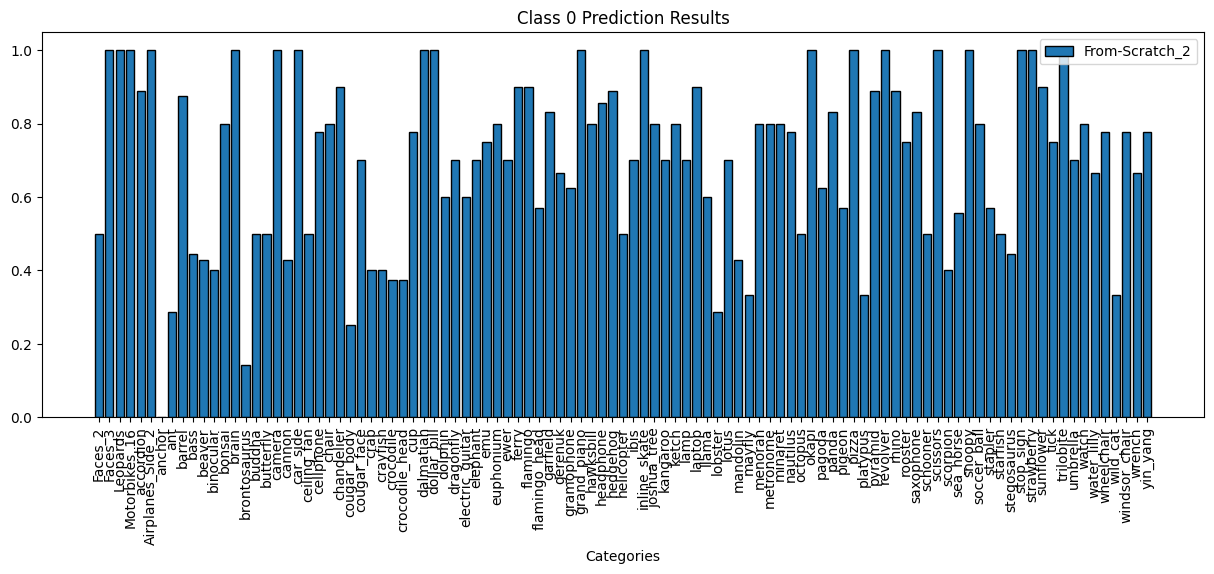

In [3]:
import numpy as np
from matplotlib import pyplot as plt

categories = dataset.annotation_categories

bottom = np.zeros(len(categories))
plt.figure(figsize=(15, 5))
# 循环绘制每组数据
for i, (group_name, group_data) in enumerate(zip(models_for_test, class_accs)):
    plt.bar(categories, 
           group_data.numpy() / len(models_for_test), 
           bottom=bottom,
           label=group_name,
        #    color=colors[i],
           edgecolor='black')
    bottom += group_data.numpy() / len(models_for_test)  # 更新底部位置

plt.xlabel("Categories")
plt.xticks(rotation=90)
# plt.ylim(0, 1.4)
plt.title("Class Accs")
plt.legend()
plt.savefig("Acc.pdf", bbox_inches='tight')
plt.show()

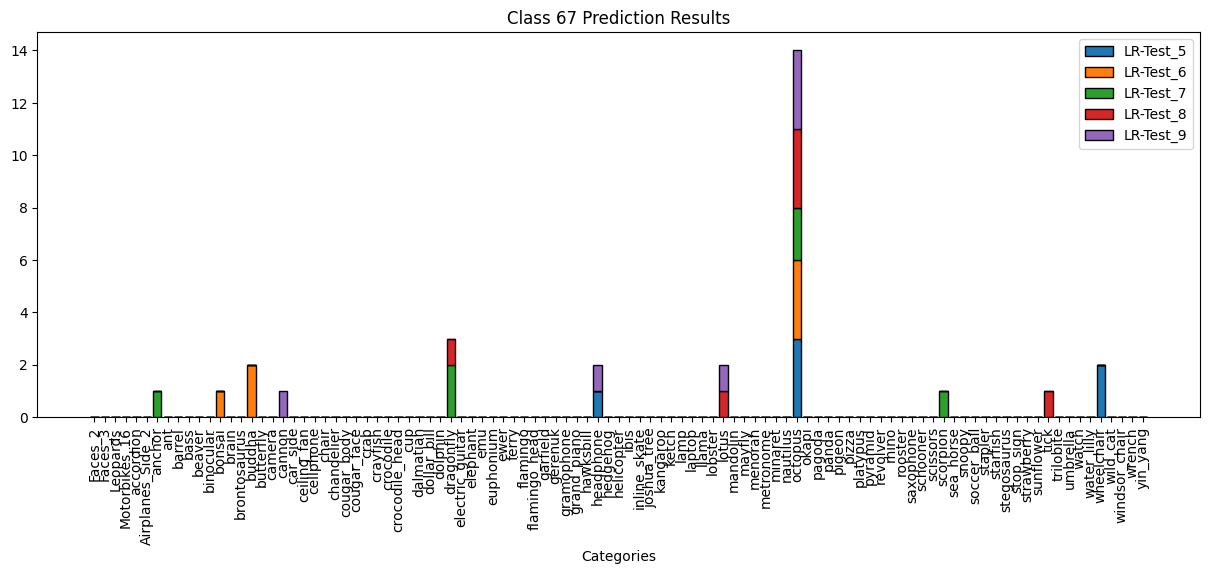

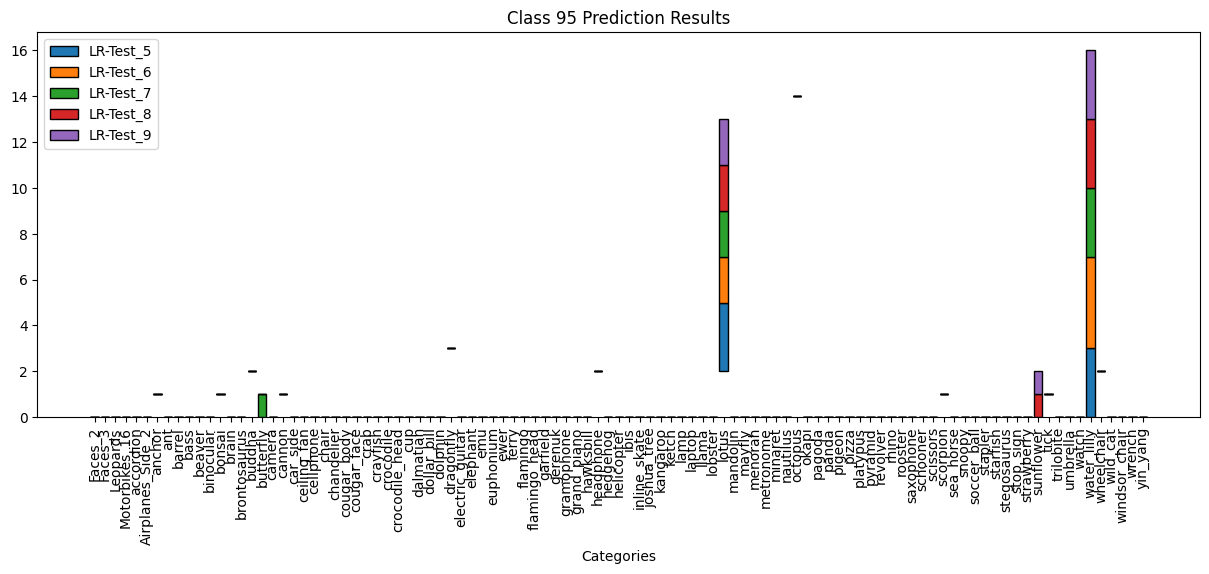

In [23]:
import numpy as np
from matplotlib import pyplot as plt

categories = dataset.annotation_categories
bottom = np.zeros(len(categories))

# 循环绘制每组数据
for c in range(len(target_class)):
    if c == 0 or c == 1 or c == 2:
        continue
    plt.figure(figsize=(15, 5))
    for i, (group_name, group_data) in enumerate(zip(models_for_test, class_predictions)):
        plt.bar(categories, 
            group_data[c].numpy(), # / len(models_for_test), 
            bottom=bottom,
            label=group_name,
            #    color=colors[i],
            edgecolor='black')
        bottom += group_data[c].numpy() # / len(models_for_test)  # 更新底部位置

    plt.xlabel("Categories")
    plt.xticks(rotation=90)
    # plt.ylim(0, 1.4)
    plt.title(f"Class {target_class[c]} Prediction Results")
    plt.legend()
    plt.savefig(f"Class_{target_class[c]}.svg", bbox_inches='tight')

In [11]:
group_data[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        3., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])